# In this notebook we will train the xgboost model

In [5]:
# ╔═════════════════════════════════════════════════════════════╗
# ║   XGBoost · BINARY direction   ·  full importance listing  ║
# ╚═════════════════════════════════════════════════════════════╝
from pathlib import Path
import warnings, numpy as np, pandas as pd
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

# ─── CONFIG ───────────────────────────────────────────────────
DATA_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                 r"\Stock-Market-Prediction\data\processed"
                 r"\gemini_btc_data_final_version_with_features_2016_final.csv")

HORIZON     = 4          # hours ahead
TEST_SIZE   = 0.20       # 20 % hold-out
RAND_SEED   = 40

warnings.filterwarnings("ignore")

# ─── 1 · Load & label (binary) ────────────────────────────────
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype(int)          # 1 = up / 0 = down
df.dropna(subset=["y"], inplace=True)

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"].astype(int)

# ─── 2 · Chronological split ─────────────────────────────────
cut = int(len(df) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

# ─── 3 · Train XGBoost (defaults) ────────────────────────────
xgb = XGBClassifier(random_state=RAND_SEED, n_jobs=-1)
xgb.fit(X_train, y_train)

# ─── 4 · Evaluate ────────────────────────────────────────────
print("\n📊 20 % hold-out macro report:")
print(classification_report(y_test, xgb.predict(X_test),
                            digits=3, zero_division=0))

# ─── 5 · Feature importance ──────────────────────────────────
feat_names = X.columns.tolist()

gain_imp = (pd.DataFrame({"Feature": feat_names,
                          "Gain_score": xgb.feature_importances_})
              .sort_values("Gain_score", ascending=False)
              .reset_index(drop=True))
gain_imp["Gain rank"] = np.arange(1, len(gain_imp)+1)

perm = permutation_importance(
           xgb, X_test, y_test,
           scoring=make_scorer(f1_score, average="macro"),
           n_repeats=5, random_state=RAND_SEED, n_jobs=-1)
perm_imp = (pd.DataFrame({"Feature": feat_names,
                          "Perm_score": perm.importances_mean})
              .sort_values("Perm_score", ascending=False)
              .reset_index(drop=True))
perm_imp["Perm rank"] = np.arange(1, len(perm_imp)+1)

full_imp = (gain_imp.merge(perm_imp, on="Feature", how="outer")
                     .loc[:, ["Feature",
                              "Gain rank", "Gain_score",
                              "Perm rank", "Perm_score"]]
                     .sort_values("Perm rank")
                     .reset_index(drop=True))

pd.set_option("display.max_rows", None,
              "display.float_format", lambda v: f"{v:10.4g}")

print("\n🔍  Combined Gain + Permutation importance (all features):")
print(full_imp.to_string(index=False))



📊 20 % hold-out macro report:
              precision    recall  f1-score   support

           0      0.498     0.618     0.552      7811
           1      0.537     0.415     0.468      8320

    accuracy                          0.514     16131
   macro avg      0.517     0.517     0.510     16131
weighted avg      0.518     0.514     0.509     16131


🔍  Combined Gain + Permutation importance (all features):
         Feature  Gain rank  Gain_score  Perm rank  Perm_score
          boll_b          6     0.06261          1     0.01075
         roc_24h          7     0.06225          2    0.004524
    upper_shadow         16     0.04645          3   0.0003643
     macd_signal          8      0.0612          4   -0.000736
              tr         11     0.05644          5  -0.0009824
       roc_7days          5     0.06342          6   -0.001004
    lower_shadow         17     0.04404          7    -0.00108
          roc_4h         13     0.05475          8   -0.001193
       macd_diff

In [4]:
# ╔════════════════════════════════════════════════════════════╗
# ║  XGBoost hyper-parameter search · precision-weighted F-score ║
# ╚════════════════════════════════════════════════════════════╝
import time, json, warnings
from math import sqrt
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import TimeSeriesSplit, HalvingRandomSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report

from xgboost import XGBClassifier

# ─── CONFIG ──────────────────────────────────────────────────────────
DATA_PATH  = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                  r"\Stock-Market-Prediction\data\processed"
                  r"\gemini_btc_data_final_version_with_features_2016_final.csv")
HORIZON, TEST_SIZE, RAND_SEED = 4, 0.20, 40
warnings.filterwarnings("ignore")

# ─── 1 · Load & label (binary) ───────────────────────────────────────
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date"))

df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"]       = (df["rel_ret"] >= 0).astype(int)
df.dropna(subset=["y"], inplace=True)

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"].astype(int)

cut         = int(len(df) * (1 - TEST_SIZE))
X_tr, X_te  = X.iloc[:cut],  X.iloc[cut:]
y_tr, y_te  = y.iloc[:cut],  y.iloc[cut:]

# ─── 2 · Search space ────────────────────────────────────────────────
param_dist = {
    "n_estimators":      np.linspace(400, 1400, 9,  dtype=int),
    "learning_rate":     np.logspace(-2.3, -0.4, 7, base=10),
    "max_depth":         np.arange(3, 11),
    "min_child_weight":  np.arange(1, 11),
    "subsample":         np.linspace(0.6, 1.0, 5),
    "colsample_bytree":  np.linspace(0.6, 1.0, 5),
    "gamma":             np.linspace(0,   5, 6),
    "reg_lambda":        np.linspace(1,  15, 8),
    "reg_alpha":         np.linspace(0,  10, 6),
}

# ─── 3 · Base model ─────────────────────────────────────────────────
base_xgb = XGBClassifier(
    objective             = "binary:logistic",
    eval_metric           = "logloss",
    random_state          = RAND_SEED,
    n_jobs                = 1,          # leave GPU free
    tree_method           = "gpu_hist",
    predictor             = "gpu_predictor",
    early_stopping_rounds = 25,         # ← major speed-up
)

# ─── 4 · Precision-weighted scorer (β = 1/√2  ⇒  precision : recall = 2 : 1)
beta          = 1 / sqrt(2)
fbeta_scoring = make_scorer(fbeta_score,
                            beta=beta,
                            average="macro",
                            zero_division=0)

# ─── 5 · Cross-validation scheme ────────────────────────────────────
tscv = TimeSeriesSplit(n_splits=5)

# ─── 6 · Successive-halving random search ───────────────────────────
searcher = HalvingRandomSearchCV(
    estimator            = base_xgb,
    param_distributions  = param_dist,
    scoring              = fbeta_scoring,
    n_candidates         = 80,
    factor               = 3,
    random_state         = RAND_SEED,
    cv                   = tscv,
    n_jobs               = 1,            # every fit uses the GPU
    verbose              = 2,
    refit                = True,
)

t0 = time.time()
searcher.fit(
    X_tr, y_tr,
    eval_set=[(X_tr.tail(5_000), y_tr.tail(5_000))],   # the small eval slice
    verbose=False,
)
print(f"\n⚡  Search finished in {time.time()-t0:.1f}s")

print("🏆  Best CV F₀.₇₀₇:", round(searcher.best_score_, 4))
print("\nBest hyper-parameters:")
for k, v in searcher.best_params_.items():
    print(f"  {k:17} = {v}")

# ─── 7 · Save params cleanly to JSON ────────────────────────────────
Path("outputs").mkdir(exist_ok=True)
serialisable = {k: (v.item() if isinstance(v, (np.integer, np.floating)) else v)
                for k, v in searcher.best_params_.items()}

with open("outputs/best_xgb_params.json", "w") as fp:
    json.dump(serialisable, fp, indent=2)

# ─── 8 · Hold-out performance ───────────────────────────────────────
best_xgb = searcher.best_estimator_
print("\n📊 20 % hold-out report (precision-weighted F):")
print(classification_report(y_te, best_xgb.predict(X_te),
                            digits=3, zero_division=0))


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 8
min_resources_: 20
max_resources_: 64524
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 20
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END colsample_bytree=0.6, gamma=5.0, learning_rate=0.005011872336272725, max_depth=8, min_child_weight=8, n_estimators=775, reg_alpha=6.0, reg_lambda=5.0, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=5.0, learning_rate=0.005011872336272725, max_depth=8, min_child_weight=8, n_estimators=775, reg_alpha=6.0, reg_lambda=5.0, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=5.0, learning_rate=0.005011872336272725, max_depth=8, min_child_weight=8, n_estimators=775, reg_alpha=6.0, reg_lambda=5.0, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=5.0, learning_rate=0.005011872336272725, max_depth=8, min_child_weight=8, n_estimators=775, reg_alpha=6.0, reg_lambda=5.

Best hyper-parameters:
  subsample         = 0.7
  reg_lambda        = 5.0
  reg_alpha         = 0.0
  n_estimators      = 1025
  min_child_weight  = 2
  max_depth         = 7
  learning_rate     = 0.3981071705534972
  gamma             = 0.0
  colsample_bytree  = 0.8

In [20]:
# ╔═══════════════════════════════════════════════════════════════════╗
# ║  XGBoost hyper-param search  (leak-free, successive halving)      ║
# ╚═══════════════════════════════════════════════════════════════════╝
import time, json, warnings, numpy as np, pandas as pd
from math import sqrt
from pathlib import Path

from sklearn.experimental import enable_halving_search_cv     # noqa: F401
from sklearn.model_selection import TimeSeriesSplit, HalvingRandomSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report

from xgboost import XGBClassifier

# ─── CONFIG ─────────────────────────────────────────────────────────
DATA_PATH   = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                   r"\Stock-Market-Prediction\data\processed"
                   r"\gemini_btc_data_final_version_with_features_2016_final.csv")
HORIZON_HRS = 4
TEST_SIZE   = 0.20          # final hold-out window
RAND_SEED   = 40
warnings.filterwarnings("ignore")

# ─── 1 · Load & label (drop NaNs BEFORE creating y) ──────────────────
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date")
        .reset_index(drop=True))

df["rel_ret"] = (df["close"].shift(-HORIZON_HRS) - df["close"]) / df["close"]
df = df.dropna(subset=["rel_ret"]).copy()          # ← no label leak
df["y"] = (df["rel_ret"] >= 0).astype(int)

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"]

# ─── 2 · Chronological train / test split with guard band ───────────
cut_raw   = int(len(df) * (1 - TEST_SIZE))
guard     = HORIZON_HRS
cut_train = max(0, cut_raw - guard)

X_tr, X_te = X.iloc[:cut_train], X.iloc[cut_raw:]
y_tr, y_te = y.iloc[:cut_train], y.iloc[cut_raw:]

print(f"Train rows : {len(X_tr):,}")
print(f"Gap rows   : {cut_raw-cut_train:,} (dropped)")
print(f"Test  rows : {len(X_te):,}")

# ─── 3 · Search space  (EXCLUDE n_estimators – it’s the resource) ───
param_dist = {
    "learning_rate":     np.logspace(-2.3, -0.4, 7, base=10),
    "max_depth":         np.arange(3, 11),
    "min_child_weight":  np.arange(1, 11),
    "subsample":         np.linspace(0.6, 1.0, 5),
    "colsample_bytree":  np.linspace(0.6, 1.0, 5),
    "gamma":             np.linspace(0,   5, 6),
    "reg_lambda":        np.linspace(1,  15, 8),
    "reg_alpha":         np.linspace(0,  10, 6),
}

# ─── 4 · Base model  (n_estimators set to MAX resource) ─────────────
MAX_ESTIMATORS = 1400
base_xgb = XGBClassifier(
    objective    = "binary:logistic",
    eval_metric  = "logloss",
    random_state = RAND_SEED,
    n_estimators = MAX_ESTIMATORS,
    tree_method  = "gpu_hist",          # change to "hist" if no GPU
    predictor    = "gpu_predictor",
    n_jobs       = 1                    # keep GPU free per fit
)

# ─── 5 · Precision-weighted Fβ  (β = 1/√2  ⇒  P:R = 2:1) ────────────
beta          = 1 / sqrt(2)
fbeta_scoring = make_scorer(fbeta_score,
                            beta=beta,
                            average="macro",
                            zero_division=0)

# ─── 6 · Time-series CV with GAP = HORIZON ───────────────────────────
tscv = TimeSeriesSplit(n_splits=5, gap=HORIZON_HRS)

# ─── 7 · Successive-halving random search  (no leakage) ─────────────
searcher = HalvingRandomSearchCV(
    estimator           = base_xgb,
    param_distributions = param_dist,
    scoring             = fbeta_scoring,
    resource            = "n_estimators",
    max_resources       = MAX_ESTIMATORS,
    min_resources       = 200,
    factor              = 3,
    n_candidates        = 80,
    random_state        = RAND_SEED,
    cv                  = tscv,
    n_jobs              = 1,         # 1 GPU fit at a time
    verbose             = 2,
    refit               = True,
)

t0 = time.time()
searcher.fit(X_tr, y_tr)            # ← no eval_set => safe for CV
print(f"\n⚡  Search finished in {time.time()-t0:.1f}s")

print("🏆  Best CV Fβ:", round(searcher.best_score_, 4))
print("\nBest hyper-parameters:")
for k, v in searcher.best_params_.items():
    print(f"  {k:17} = {v}")

# ─── 8 · Save params to JSON ─────────────────────────────────────────
Path("outputs").mkdir(exist_ok=True)
serialisable = {k: (v.item() if isinstance(v, (np.integer, np.floating)) else v)
                for k, v in searcher.best_params_.items()}
with open("outputs/best_xgb_params.json", "w") as fp:
    json.dump(serialisable, fp, indent=2)

# ─── 9 · Hold-out performance (20 % window) ─────────────────────────
best_xgb = searcher.best_estimator_
print("\n📊 20 % hold-out report:")
print(classification_report(y_te, best_xgb.predict(X_te),
                            digits=3, zero_division=0))


Train rows : 64,516
Gap rows   : 4 (dropped)
Test  rows : 16,131
n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 200
max_resources_: 1400
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 200
Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END colsample_bytree=0.8, gamma=2.0, learning_rate=0.19201419386388022, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=2.0, reg_lambda=13.0, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=2.0, learning_rate=0.19201419386388022, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=2.0, reg_lambda=13.0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=2.0, learning_rate=0.19201419386388022, max_depth=3, min_child_weight=1, n_estimators=200, reg_alpha=2.0, reg_lambda=13.0, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=2.0, learning_rate=0.19201419386388022, max_depth=3, m

⚡  Search finished in 341.2s
🏆  Best CV Fβ: 0.5235

Best hyper-parameters:
  subsample         = 0.8
  reg_lambda        = 5.0
  reg_alpha         = 8.0
  min_child_weight  = 9
  max_depth         = 8
  learning_rate     = 0.3981071705534972
  gamma             = 4.0
  colsample_bytree  = 0.6
  n_estimators      = 600

# Trainig the xgboost model

In [23]:
# ╔═════════════════════════════════════════════════════════════════════╗
# ║  BTC · Up/Down prediction (leak-free, tuned XGB, confidence table)  ║
# ╚═════════════════════════════════════════════════════════════════════╝
import time, warnings, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    precision_recall_fscore_support
)
from xgboost import XGBClassifier

# ─── CONFIG ───────────────────────────────────────────────────────────
DATA_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                 r"\Stock-Market-Prediction\data\processed"
                 r"\gemini_btc_data_final_version_with_features_2016_final.csv")

HORIZON_HOURS   = 4          # look-ahead horizon
TEST_SIZE       = 0.20       # share of rows in final hold-out
RAND_SEED       = 40
CONF_THRESHOLDS = [0.50, 0.60, 0.70, 0.80]    # confidence bars
warnings.filterwarnings("ignore")

# ─── 1 · Load & label ────────────────────────────────────────────────
df = (pd.read_csv(DATA_PATH, parse_dates=["date"])
        .sort_values("date")
        .reset_index(drop=True))

df["rel_ret"] = (df["close"].shift(-HORIZON_HOURS) - df["close"]) / df["close"]
df = df.dropna(subset=["rel_ret"]).copy()          # drop NaNs → no label leak
df["y"] = (df["rel_ret"] >= 0).astype(int)         # 1 = up/flat, 0 = down

# ─── 2 · Features ────────────────────────────────────────────────────
drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"]

# ─── 3 · Chronological split with guard band ────────────────────────
cut_raw   = int(len(df) * (1 - TEST_SIZE))
guard     = HORIZON_HOURS
cut_train = max(0, cut_raw - guard)

X_tr, X_te = X.iloc[:cut_train], X.iloc[cut_raw:]
y_tr, y_te = y.iloc[:cut_train], y.iloc[cut_raw:]

print(f"Train rows : {len(X_tr):,}")
print(f"Gap rows   : {cut_raw-cut_train:,}  (dropped)")
print(f"Test  rows : {len(X_te):,}")

# ─── 4 · XGBoost model (best hyper-parameters) ───────────────────────
best_params = {
    "subsample"        : 0.8,
    "reg_lambda"       : 5.0,
    "reg_alpha"        : 8.0,
    "n_estimators"     : 600,
    "min_child_weight" : 9,
    "max_depth"        : 8,
    "learning_rate"    : 0.3981071705534972,
    "gamma"            : 4.0,
    "colsample_bytree" : 0.6,
}

model = XGBClassifier(
    objective    = "binary:logistic",
    eval_metric  = "logloss",
    random_state = RAND_SEED,
    n_jobs       = -1,
    tree_method  = "gpu_hist",      # switch to "hist" if no GPU
    predictor    = "gpu_predictor",
    **best_params
)

tic = time.time()
model.fit(X_tr, y_tr)
print(f"\n⏱  Training done in {time.time()-tic:,.1f}s")

# ─── 5 · Overall test metrics  (decision threshold = 0.50) ───────────
proba_pos = model.predict_proba(X_te)[:, 1]
y_hat     = (proba_pos >= 0.50).astype(int)

print(f"ROC-AUC (test) : {roc_auc_score(y_te, proba_pos):.3f}")
print("Confusion matrix @ 0.50:\n", confusion_matrix(y_te, y_hat))

# ─── 6 · Confidence-filtered table (tidy two-row format) ─────────────
records = []
for thr in CONF_THRESHOLDS:
    confident = (proba_pos >= thr) | (proba_pos <= 1 - thr)
    kept      = int(confident.sum())
    if kept == 0:
        continue

    yt = y_te[confident]
    yh = y_hat[confident]           # decision rule fixed at 0.50

    prec, rec, f1, _ = precision_recall_fscore_support(
        yt, yh, labels=[0, 1], zero_division=0
    )

    # class 0 – Down
    records.append({
        "Threshold":      f"{thr:4.2f}",
        "Class":          "Down (0)",
        "Rows evaluated": kept,
        "Precision":      prec[0],
        "Recall":         rec[0],
        "F1-score":       f1[0],
    })
    # class 1 – Up
    records.append({
        "Threshold":      f"{thr:4.2f}",
        "Class":          "Up   (1)",
        "Rows evaluated": kept,
        "Precision":      prec[1],
        "Recall":         rec[1],
        "F1-score":       f1[1],
    })

conf_tbl = (pd.DataFrame(records)
              .set_index(["Threshold", "Class"])
              .sort_index())

print("\n════════ Confidence-filtered metrics ════════")
print(conf_tbl.to_string(float_format="{:.3f}".format))


Train rows : 64,516
Gap rows   : 4  (dropped)
Test  rows : 16,131

⏱  Training done in 0.9s
ROC-AUC (test) : 0.532
Confusion matrix @ 0.50:
 [[5437 2371]
 [5469 2854]]

════════ Confidence-filtered metrics ════════
                    Rows evaluated  Precision  Recall  F1-score
Threshold Class                                                
0.50      Down (0)           16131      0.499   0.696     0.581
          Up   (1)           16131      0.546   0.343     0.421
0.60      Down (0)            4851      0.517   0.821     0.635
          Up   (1)            4851      0.561   0.230     0.326
0.70      Down (0)             289      0.547   0.864     0.670
          Up   (1)             289      0.543   0.185     0.276


In [1]:
# ───────── CONFIG ─────────
import warnings, numpy as np, pandas as pd, time
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, make_scorer

DATA_PATH = Path(r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction"
                 r"\Stock-Market-Prediction\data\processed"
                 r"\gemini_btc_data_final_version_with_features_2016_final.csv")

HORIZON_HOURS = 4
TEST_SIZE     = 0.20
RAND_SEED     = 40

best_params = {
    "subsample"        : 0.8,
    "reg_lambda"       : 5.0,
    "reg_alpha"        : 8.0,
    "n_estimators"     : 600,
    "min_child_weight" : 9,
    "max_depth"        : 8,
    "learning_rate"    : 0.3981071705534972,
    "gamma"            : 4.0,
    "colsample_bytree" : 0.6,
}

# ───────── LOAD & LABEL ─────────
warnings.filterwarnings("ignore")
np.random.seed(RAND_SEED)

df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
df["rel_ret"] = (df["close"].shift(-HORIZON_HOURS) - df["close"]) / df["close"]
df = df.dropna(subset=["rel_ret"]).copy()
df["y"] = (df["rel_ret"] >= 0).astype(int)

drop_cols = ["date", "rel_ret", "y", "open", "high", "low", "macd_line"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df["y"]

# ───────── SPLIT ─────────
cut_raw   = int(len(df) * (1 - TEST_SIZE))
cut_train = cut_raw - HORIZON_HOURS
X_tr, X_te = X.iloc[:cut_train], X.iloc[cut_raw:]
y_tr, y_te = y.iloc[:cut_train], y.iloc[cut_raw:]

# ───────── TRAIN ─────────
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RAND_SEED,
    n_jobs=-1,
    tree_method="hist",        # Use "hist" instead of "gpu_hist"
    predictor="auto",          # Safe fallback
    **best_params
)

tic = time.time()
model.fit(X_tr, y_tr)
print(f"\n⏱ Training completed in {time.time()-tic:.1f} seconds.")

# ───────── IMPORTANCE ─────────
feat_names = X.columns.tolist()

# Gini
gini_df = pd.DataFrame({
    "Feature": feat_names,
    "Gini_score": model.feature_importances_
}).sort_values("Gini_score", ascending=False).reset_index(drop=True)
gini_df["Gini rank"] = np.arange(1, len(gini_df)+1)

# Permutation
perm = permutation_importance(
    model, X_te, y_te,
    scoring=make_scorer(f1_score, average="macro"),
    n_repeats=10,
    random_state=RAND_SEED,
    n_jobs=-1
)
perm_df = pd.DataFrame({
    "Feature": feat_names,
    "Perm_score": perm.importances_mean
}).sort_values("Perm_score", ascending=False).reset_index(drop=True)
perm_df["Perm rank"] = np.arange(1, len(perm_df)+1)

# Combine
final_df = (gini_df.merge(perm_df, on="Feature", how="outer")
            .loc[:, ["Feature", "Gini rank", "Gini_score", "Perm rank", "Perm_score"]]
            .sort_values("Perm rank")
            .reset_index(drop=True))

# Show all
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", "{:10.4g}".format)
print("\n🔍 Combined Feature Importance (XGBoost):")
print(final_df.to_string(index=False))



⏱ Training completed in 0.6 seconds.

🔍 Combined Feature Importance (XGBoost):
         Feature  Gini rank  Gini_score  Perm rank  Perm_score
          boll_b          2     0.07381          1     0.02068
         roc_24h          4     0.05955          2    0.009542
       roc_7days          8     0.05676          3    0.003415
            body          6     0.05881          4    0.002648
    ret_over_atr          1     0.07976          5    0.001999
    lower_shadow         17     0.04854          6    0.001899
          atr_14          5      0.0591          7    0.001644
          roc_4h         11     0.05627          8    0.001486
price_above_ma50          9     0.05647          9    0.001117
    upper_shadow         10     0.05638         10   0.0004487
     macd_signal         14     0.05234         11   0.0003997
              tr         15     0.05216         12   0.0003406
           close          3     0.07208         13   0.0001301
       macd_diff         12     0.0537

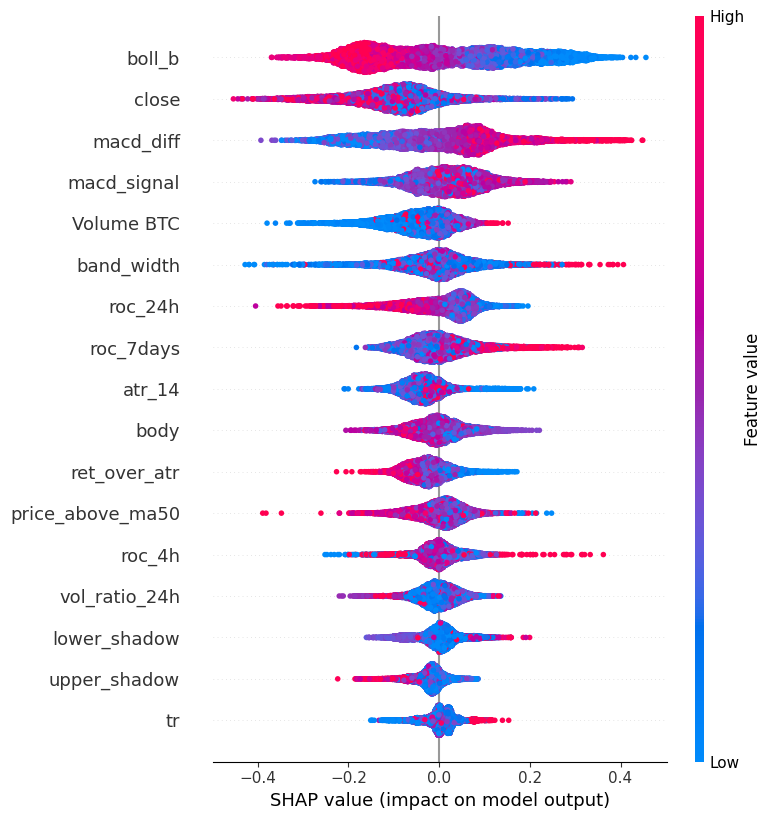

In [2]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_te, check_additivity=False)
shap.summary_plot(shap_values, X_te, show=False)
